In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [20]:
path = "Interest rate.xlsx"
col_names = ["30yr","10yr","5yr","2yr","1yr","6mo","3mo_libor","3mo_sofr","1mo_libor", "1mo_sofr"]



#df_libor = df_libor.dropna(axis=0, how="any").loc[:,"Mid Price":"1mo_libor"]
#df_sofr = df_sofr.dropna(axis=0, how="any").loc[:,"Mid Price":"1mo_sofr"]

In [45]:
interest_rate_libor = []
interest_rate_sofr = []
for i in col_names:
    df=pd.read_excel(path, sheet_name=i)
    if "libor" in i:    
        interest_rate_libor.append(df)
        continue
    if "sofr" in i:
        interest_rate_sofr.append(df)
        continue
    interest_rate_libor.append(df)
    interest_rate_sofr.append(df)
#df_libor_1d = pd.read_excel(path,sheet_name="1d")
#df_libor_3m = pd.read_excel(path,sheet_name="3mo_libor")


In [46]:
result_libor = pd.read_excel(path,sheet_name="1d")
for i in range(len(interest_rate_libor)):
    result_libor = pd.merge(result_libor,interest_rate_libor[i],on = "Date",how="outer")
result_libor.dropna(inplace=True)
result_libor.set_index("Date",inplace=True)

In [54]:
result_sofr = pd.read_excel(path,sheet_name="1d")
for i in range(len(interest_rate_sofr)):
    result_sofr = pd.merge(result_sofr,interest_rate_sofr[i],on = "Date",how="outer")
result_sofr.dropna(inplace=True)
result_sofr.set_index("Date",inplace=True)

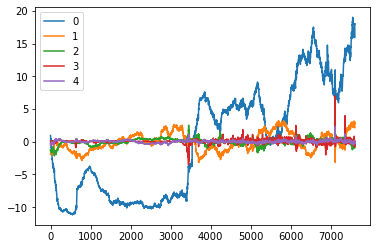

In [53]:
# only libor below

pca = PCA(n_components=5)
components = pca.fit_transform(result_libor)
df_components = pd.DataFrame(data=components)
df_components.plot() 

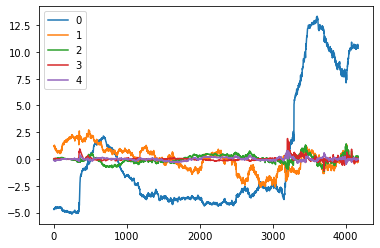

In [55]:
# only sofr below

pca = PCA(n_components=5)
components = pca.fit_transform(result_sofr)
df_components = pd.DataFrame(data=components)
df_components.plot() 

In [15]:
def count_negative(nums):
    count = 0
    for i in nums:
        if i<0:
            count+=1
    return count

In [17]:
count_negative(df_components.iloc[:,0])

4757

In [14]:
df_components

0         1         2         3         4
0      0.658334  1.276481 -1.318490  0.979339 -0.305794
1      0.676220  1.268508 -1.369794  1.083281 -0.320474
2      0.550786  1.294711 -1.407213  1.041271 -0.282382
3      0.450323  1.350424 -1.449949  1.043718 -0.253978
4      0.141514  1.121894 -1.218147  1.097271 -0.775742
...         ...       ...       ...       ...       ...
9527  18.714344  4.438582  6.503658  1.957586 -0.106546
9528  18.910517  4.579731  6.427063  1.759678 -0.121772
9529  18.855187  4.623981  6.342444  1.625791 -0.096768
9530  18.872021  4.543275  6.383067  1.546637 -0.210927
9531  18.706535  4.681379  6.355257  1.457452 -0.337361

[9532 rows x 5 columns]

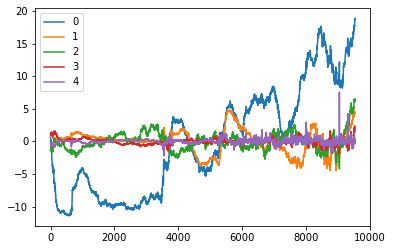

In [13]:
components = pca.fit_transform(df_libor)
df_components = pd.DataFrame(data=components)
df_components.plot() 

### CIR

In [52]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class CIRParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float  # Brownian motion scale factor (standard deviation)

    def __post_init__(self) -> Optional[NoReturn]:
        if 2 * self.a * self.b < self.c ** 2:
            raise ValueError("2ab has to be less than or equal to c^2.")
        return None

In [56]:
from typing import Optional, NoReturn, Any

import numpy as np

import brownian_motion

def get_CIR_process(
    T: int,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    dW = brownian_motion.get_dW(T, random_state)
    return _generate_CIR_process(dW, CIR_params, sigma_0)


def _generate_CIR_process(
    dW: np.ndarray,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the CIR process given the Brownian motion.
    - dW is a 1D array with the Brownian motion increments.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    T = len(dW)
    _sigma_0 = _select_sigma_0(sigma_0, CIR_params)
    sigma_t = [_sigma_0]
    for t in range(1, T):
        dsigma_t = (
            CIR_params.a * (CIR_params.b - sigma_t[t - 1])
            + CIR_params.c * np.sqrt(sigma_t[t - 1]) * dW[t]
        )
        # if Nan in simulation raise an error.
        _validate_not_nan(dsigma_t)
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], CIR_params: CIRParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return CIR_params.b


def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
    if np.isnan(dsigma_t):
        raise ValueError(
            "CIR process simulation crashed, check your CIR_params. "
            + "Maybe choose a smaller c value."
        )
    return None

In [58]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_CIR_params(sigma_t: np.ndarray) -> CIRParams:
    """
    Estimate CIR params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return CIRParams(a, b, c)

### OU

In [78]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class OUParams:
    """OU process params."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float

In [79]:
from typing import Optional, NoReturn, Any

import numpy as np

import brownian_motion

def get_OU_process(
    T: int,
    OU_params: OUParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - OU_params is an instance of OUParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    dW = brownian_motion.get_dW(T, random_state)
    #print(dW)
    return _generate_OU_process(dW, OU_params, sigma_0)


def _generate_OU_process(
    dW: np.ndarray,
    OU_params: OUParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the OU process given the Brownian motion.
    - dW is a 1D array with the Brownian motion increments.
    - OU_params is an instance of OUParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    T = len(dW)
    _sigma_0 = _select_sigma_0(sigma_0, OU_params)
    sigma_t = [_sigma_0]
    for t in range(1, T):
        dsigma_t = (
            OU_params.a * (OU_params.b - sigma_t[t - 1]) + OU_params.c * dW[t]
        )
        # if Nan in simulation raise an error.
        #_validate_not_nan(dsigma_t)
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], OU_params: OUParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return OU_params.b


#def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
#    if np.isnan(dsigma_t):
#        raise ValueError(
#            "OU process simulation crashed, check your OU_params. "
#            + "Maybe choose a smaller c value."
#        )
#    return None

In [83]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_OU_params(sigma_t: np.ndarray) -> OUParams:
    """
    Estimate OU params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma = sigma_t[:-1]
    y = np.diff(sigma_t)
    x2 = sigma
    x1 = np.array([1.0]*len(x2))
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return OUParams(a, b, c)

OUParams(a=0.0007474642720206848, b=-0.6364135477988722, c=0.0539616695040069)
OUParams(a=0.002351918593072673, b=-0.1672170429776351, c=0.06928534586837151)


<AxesSubplot:>

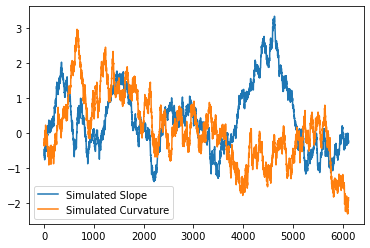

In [294]:
proc_slope = df_components.Slope.to_numpy()
proc_curvature = df_components.Curvature.to_numpy()

est_param_slope = estimate_OU_params(proc_slope)
est_param_curvature = estimate_OU_params(proc_curvature)
print(est_param_slope)
print(est_param_curvature)

sim_slope = get_OU_process(len(df_components), est_param_slope)
sim_curvature = get_OU_process(len(df_components), est_param_curvature)

#x1 = np.linspace(0,len(df_components)-1,len(df_components))
#x2 = np.linspace(0,len(df_components)-1,len(df_components))
#plt.plot(x1, sim_slope)
#plt.plot(x2, sim_curvature)
#plt.show()

temp = pd.DataFrame({"Simulated Slope": sim_slope, "Simulated Curvature": sim_curvature})
temp.plot()

#plt.plot(sim_curvature)

<AxesSubplot:>

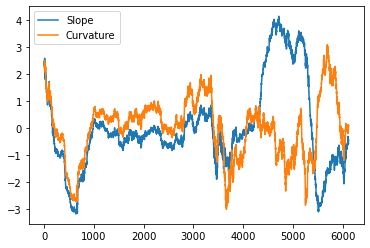

In [120]:
df_components.plot(y=["Slope", "Curvature"])

In [97]:
1_000

1000

In [98]:
len(df_components)

6116

In [84]:
OU_params = OUParams(a=0.05, b=0.5, c=0.02)
OU_proc = get_OU_process(1_000, OU_params, random_state=3)
OU_proc
OU_params_hat = estimate_OU_params(OU_proc)
OU_params_hat
#np.array([1.0]*5)

OUParams(a=0.051307254225921424, b=0.5062038259112392, c=0.020146771382880613)

In [35]:
df_sofr

Mid Price    30yr    10yr     5yr     2yr     1yr     6mo  3mo_sofr  \
0          3.83  4.2671  4.1689  4.3344  4.6563  4.7144  4.5497   0.04923   
1          3.83  4.1812  4.1469  4.3677  4.7138  4.7565  4.5806   0.04924   
2          3.83  4.1405  4.1005  4.3093  4.6197  4.6945  4.5520   0.04924   
3          3.83  4.0919  4.0419  4.2670  4.5447  4.6258  4.5838   0.04924   
4          3.08  4.1639  4.0478  4.2283  4.4824  4.6019  4.5359   0.04924   
...         ...     ...     ...     ...     ...     ...     ...       ...   
6111       5.51  5.7900  5.5500  5.5450  5.5120  5.4650  5.2920   5.50779   
6112       5.65  5.7770  5.5280  5.5270  5.5040  5.4870  5.2920   5.50978   
6113       5.42  5.8020  5.5520  5.5490  5.5210  5.6200  5.2570   5.51028   
6114       5.57  5.8250  5.5690  5.5890  5.5460  5.6320  5.3110   5.51111   
6115       5.70  5.8460  5.5770  5.5890  5.5750  5.6660  5.3350   5.51328   

      1mo_sofr  
0      0.04759  
1      0.04767  
2      0.04767  
3      0.04767  
4      0.04807  
...        ...  
6111   5.45019  
6112   5.44751  
6113   5.44584  
6114   5.43849  
6115   5.43750  

[6116 rows x 9 columns]